In [1]:
!pip install -q langgraph langchain-openai langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.1/500.1 kB 36.5 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [3]:
import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

### Define Agent State

In [5]:
class EmailState(TypedDict):
    email_input: str
    intent: str
    tone: str
    draft_reply: str
    final_reply: str

### Load OpenAI Model

In [6]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.3
)

### Create Agent Nodes

1. Intent Analyzer Agent

In [7]:
def intent_agent(state: EmailState):
    prompt = ChatPromptTemplate.from_template(
        """
        Analyze the email and identify the main intent.

        Email:
        {email}

        Output only short intent.
        """
    )

    chain = prompt | llm
    result = chain.invoke({"email": state["email_input"]})

    return {"intent": result.content}

2. Tone Selector Agent

In [8]:
def tone_agent(state: EmailState):
    prompt = ChatPromptTemplate.from_template(
        """
        Based on intent below, choose best professional tone.

        Intent: {intent}

        Possible tones:
        - Formal
        - Friendly
        - Apologetic
        - Assertive

        Return only tone.
        """
    )

    chain = prompt | llm
    result = chain.invoke({"intent": state["intent"]})

    return {"tone": result.content}

3. Reply Generator Agent

In [9]:
def reply_agent(state: EmailState):
    prompt = ChatPromptTemplate.from_template(
        """
        Write a professional email reply.

        Tone: {tone}
        Intent: {intent}

        Original Email:
        {email}

        Keep it clear, short and professional.
        """
    )

    chain = prompt | llm
    result = chain.invoke({
        "tone": state["tone"],
        "intent": state["intent"],
        "email": state["email_input"]
    })

    return {"draft_reply": result.content}

4. Quality Reviewer Agent

In [10]:
def reviewer_agent(state: EmailState):
    prompt = ChatPromptTemplate.from_template(
        """
        Improve the email reply to make it:

        - OEM professional
        - grammatically perfect
        - clear and concise

        Draft:
        {draft}
        """
    )

    chain = prompt | llm
    result = chain.invoke({"draft": state["draft_reply"]})

    return {"final_reply": result.content}

Build LangGraph Workflow

In [11]:
builder = StateGraph(EmailState)

builder.add_node("intent_agent", intent_agent)
builder.add_node("tone_agent", tone_agent)
builder.add_node("reply_agent", reply_agent)
builder.add_node("reviewer_agent", reviewer_agent)

builder.set_entry_point("intent_agent")

builder.add_edge("intent_agent", "tone_agent")
builder.add_edge("tone_agent", "reply_agent")
builder.add_edge("reply_agent", "reviewer_agent")
builder.add_edge("reviewer_agent", END)

graph = builder.compile()

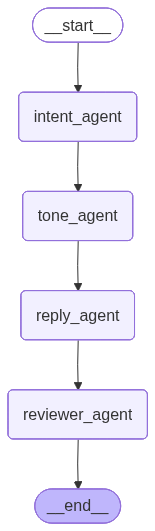

In [12]:
graph

Run the Agent

In [13]:
input_email = """
Dear Team,

I hope you are doing well.

Could you please share the latest status report for the Agentic AI project? I would like to review the current progress, completed milestones, pending tasks, and any challenges or risks that need attention. If available, please include updates on recent testing outcomes and the next planned steps.

Kindly send the report at your earliest convenience so we can stay aligned on timelines and priorities.

Thank you, and I look forward to your update.

Best regards,
Jose Roberto
"""

In [14]:
result = graph.invoke({
    "email_input": input_email
})

print(result["final_reply"])

Subject: Re: Request for Status Report on Agentic AI Project

Dear Jose,

Thank you for your inquiry regarding the Agentic AI project.

I am currently compiling the latest status report, which will include progress updates, completed milestones, pending tasks, challenges we are facing, recent testing outcomes, and our next steps. 

You can expect to receive the report shortly.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  
